Install packages and mount google drive

In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/MIDS-GNN')

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Remove processed data if needed

In [ ]:
!rm -rf Dataset/processed/

Initialize dataset

In [3]:
import random
from pathlib import Path

import matplotlib
import networkx as nx
import torch
import torch_geometric.utils as pygUtils
import Utilities.utils as utils
import yaml
from matplotlib import pyplot as plt
from torch_geometric.data import InMemoryDataset, download_url, extract_zip
from tqdm import tqdm
import random

class MIDSdataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, **kwargs):
        self.raw_included_subdirs = kwargs.get("raw_included_subdirs", None)

        super().__init__(root, transform, pre_transform, pre_filter)

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        """
        Return a list of all raw files in the dataset.

        This method has two jobs. The returned list with raw files is compared
        with the files currently in raw directory. Files that are missing are
        automatically downloaded using download method. The second job is to
        return the list of raw file names that will be used in the process
        method.
        """
        raw_dir = Path(self.raw_dir)
        raw_files = []
        with open(raw_dir.parent / "file_list.yaml", "r") as file:
            raw_dir_structure = yaml.safe_load(file)
            for subdir in raw_dir_structure:
                if self.raw_included_subdirs is None or subdir in self.raw_included_subdirs:
                    raw_files.extend([f"{subdir}/{filename}" for filename in raw_dir_structure[subdir]])

        return raw_files

    @property
    def processed_file_names(self):
        """
        Return a list of all processed files in the dataset.

        If a processed file is missing, it will be automatically created using
        the process method.

        That means that if you want to reprocess the data, you need to delete
        the processed files and reimport the dataset.
        """
        # TODO: Automatically detect changes in the dataset.
        #       We could come up with a namig scheme that will differentiate
        #       which graph families (and/or sizes) and features were used to
        #       generate the dataset. This way, we could detect changes and
        #       reprocess the dataset when needed.
        return ["data.pt"]

    def download(self):
        """Automatically download raw files if missing."""
        # TODO: Should check and download only missing files.

        zip_file = Path(self.root) / "raw_data.zip"

        # Delete the exising zip file.
        zip_file.unlink(missing_ok=True)

        # Download the raw files using the helper function.
        download_url(raw_download_url, self.root, filename="raw_data.zip")

        # Unzip the downloaded files.
        extract_zip(str(zip_file.resolve()), self.raw_dir)

    def process(self):
        """Process the raw files into a graph dataset."""
        # Read data into huge `Data` list.
        data_list = []
        with tqdm(total=len(self.raw_file_names)) as pbar:
            for graph_file in self.raw_file_names:
                data = self.make_data(Path(self.raw_dir) / graph_file)
                if data:
                    data_list.extend(data)
                pbar.update(1)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def make_data(self, graph_file):
        """Create a PyG data object from a graph file."""
        G = nx.read_edgelist(graph_file, nodetype=int)

        # Define features in use.
        feature_functions = {
            "degree": G.degree,
            "degree_centrality": nx.degree_centrality(G),
            "betweenness_centrality": nx.betweenness_centrality(G),
            #"avg_neighbor_degree": nx.average_neighbor_degree(G),
            #"number_of_cliques": nx.number_of_cliques(G), # mozda kompleksno
        }

        # Compute and add features to the nodes in the graph.
        #print(" ")
        #print(nx.voterank(G))
        for node in G.nodes():
            for feature in feature_functions:
                #print(f'feature: {feature}')
                #print(f'node: {node}')
                #print(feature_functions[feature][node])
                G.nodes[node][feature] = feature_functions[feature][node]

        # for node in G.nodes():
        #     G.nodes[node]["degree"] = G.degree(node)

        # degree_cent = nx.degree_centrality(G)
        # for node in G.nodes():
        #     G.nodes[node]["degree_centrality"] = degree_cent[node]

        # between_cent = nx.betweenness_centrality(G)
        # for node in G.nodes():
        #     G.nodes[node]["betweenness_centrality"] = between_cent[node]

        torch_G = pygUtils.from_networkx(G, group_node_attrs=list(feature_functions.keys()))
        true_labels = MIDSdataset.get_labels(utils.find_MIDS(G), G.number_of_nodes())
        data = []
        #if len(true_labels) == 1:
        #    data.append(torch_G.clone())
        #    data[-1].y = true_labels[0]
        #    return data
        #else:
        #    return 0
        for labels in true_labels:
            data.append(torch_G.clone())
            data[-1].y = labels

        return [data[0]]

    @staticmethod
    def get_labels(mids, num_nodes):
        # Encode found cliques as support vectors.
        for i, nodes in enumerate(mids):
            mids[i] = torch.zeros(num_nodes)
            mids[i][nodes] = 1

        return mids

    @staticmethod
    def visualize_data(data):
        G = pygUtils.to_networkx(data, to_undirected=True)
        nx.draw(G, with_labels=True, node_color=data.y, cmap=matplotlib.colormaps["bwr"])
        plt.show()

Load dataset

In [4]:
from pathlib import Path
root = Path.cwd() / "Dataset"
raw_included_subdirs = None

dataset = MIDSdataset(root, raw_included_subdirs=raw_included_subdirs)

print()
print(f"Dataset: {dataset}:")
print("====================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")


Dataset: MIDSdataset(3171):
Number of graphs: 3171
Number of features: 7
Number of classes: 2


Check MIDS function for testing

In [5]:
def check_MIDS(A, candidate, target_value):
    """
    Args:
        - A: adjacency matrix
        - candidate: node labels that are candidate for MIDS (data.y)
        - target_value: known size of the MIDS
    """
    # TODO: This function needs to be adjusted.
    #   - Instead of adjacency matrix, we may pass the edgelist and convert it here

    n = len(candidate)

    # Candidate set is not minimal
    if sum(candidate) > target_value:
        return False

    # Candidate set is not dominating and independent
    if not all((A + np.eye(n)) @ candidate == 1):
        return False

    if sum(candidate) < target_value:
        print("Somehow we found an even smaller MIDS.")

    return True

Define GNN structure

In [6]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv

torch.manual_seed(12345)
dataset = dataset.shuffle()

# split dataset into train and test
train_dataset = dataset[:3000]
test_dataset = dataset[3000:3171]

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

Train a model

In [ ]:
import numpy as np

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_op = torch.nn.CrossEntropyLoss()


def train():
    model.train()

    total_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        real = data.y.type(torch.LongTensor)
        loss = loss_op(pred, real)

        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    correct = 0
    correct_checkMIDS = 0
    for i, data in enumerate(loader):
        for idx in range(data.num_graphs):
          out = model(data.get_example(idx).x.to(device), data.get_example(idx).edge_index.to(device))
          pred = out.argmax(dim=1)

          correct += int(torch.equal(pred,data.get_example(idx).y.type(torch.LongTensor)))  # Derive ratio of correct predictions.

          #num_nodes = data.get_example(idx).x.size(0)
          #adjacency = torch.sparse_coo_tensor(data['edge_index'], torch.ones(data['edge_index'].size(1)), (num_nodes, num_nodes))
          #adjacency_dense = adjacency.to_dense()
          #correct_checkMIDS += check_MIDS(adjacency_dense, pred.type(torch.DoubleTensor), len(data.y))

    return [correct, correct_checkMIDS]/len(loader.dataset)*100


times = []
losses = []
trains = []
tests = []

for epoch in range(1, 201):
    start = time.time()

    loss = train()
    losses.append(loss)

    train_f1 = test(train_loader)
    trains.append(train_f1)

    test_f1 = test(test_loader)
    tests.append(test_f1)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_f1:.4f}% '
          f'Test: {test_f1:.4f}%, Time: {(time.time() - start)/60:.2f} min')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Plot loss and train and test accuracy

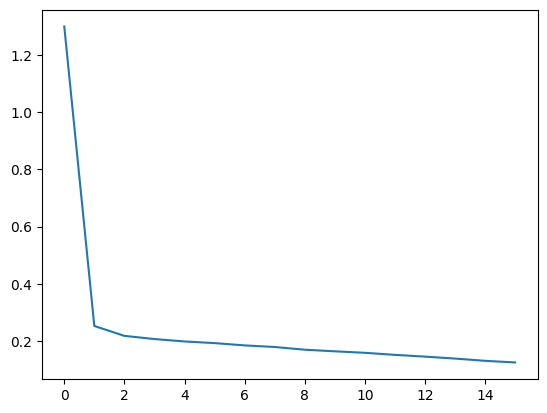

In [8]:
import matplotlib.pyplot as pp
pp.plot(losses)
pp.show()

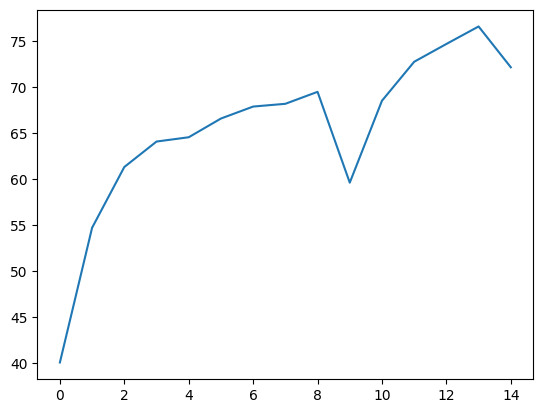

In [9]:
pp.plot(trains)
pp.show()

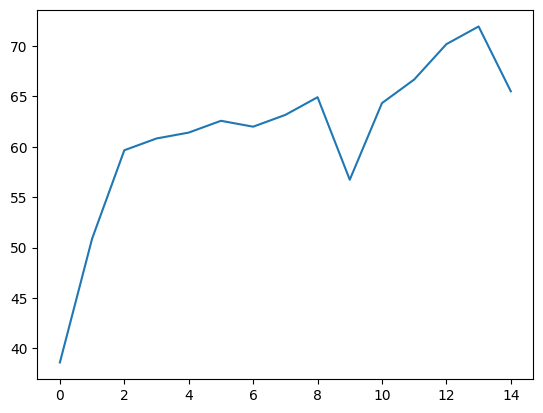

In [10]:
pp.plot(tests)
pp.show()

Save/Load a model

In [ ]:
torch.save(model, '3000g_6f.pth')

In [ ]:
loaded = torch.load('3000g_6f.pth')

Testing a loaded model

In [ ]:
@torch.no_grad()
def test(loader):
    loaded.eval()
    #return 0
    correct = 0
    ys, preds = [], []
    for i, data in enumerate(loader):
        #print(data)
        for idx in range(data.num_graphs):
          #ys.append(data.y)
          out = loaded(data.get_example(idx).x.to(device), data.get_example(idx).edge_index.to(device))
          pred = out.argmax(dim=1)
          #preds.append((out > 0).float().cpu())
          correct += int(torch.equal(pred,data.get_example(idx).y.type(torch.LongTensor)))  # Derive ratio of correct predictions.

    return correct/len(loader.dataset)*100

loader = DataLoader(dataset, batch_size=128, shuffle=False)
test(loader)

Visualize wrong predictions

In [ ]:
for i in range(20):
  d = dataset[i]
  predik = loaded(d.x, d.edge_index).argmax(dim=1)
  if not torch.equal(predik, d.y.type(torch.LongTensor)):
    examine_pred(d, predik)
    print(loaded(d.x, d.edge_index))